In [1]:
pip install pandas


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cm/local/apps/python39/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 491 kB 3.7 MB/s            
     |████████████████████████████████| 183 kB 58.8 MB/s            
     |████████████████████████████████| 133 kB 105.1 MB/s            
     |████████████████████████████████| 481 kB 113.1 MB/s            
     |████████████████████████████████| 116 kB 147.7 MB/s            
     |████████████████████████████████| 78 kB 33.1 MB/s             
     |████████████████████████████████| 193 kB 178.3 MB/s            
     |████████████████████████████████| 42.1 MB 192.7 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consid

In [4]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.4 MB 3.8 MB/s            
     |████████████████████████████████| 780 kB 177.1 MB/s            
     |████████████████████████████████| 471 kB 130.3 MB/s            
     |████████████████████████████████| 3.0 MB 83.0 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/cm/local/apps/python39/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.5 MB 3.5 MB/s            
     |████████████████████████████████| 38.6 MB 192.2 MB/s            
     |████████████████████████████████| 301 kB 105.1 MB/s            
You should consider upgrading via the '/cm/local/apps/python39/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 766.7 MB 15 kB/s               
     |████████████████████████████████| 150.1 MB 127.9 MB/s            
     |████████████████████████████████| 6.2 MB 191.4 MB/s            
     |████████████████████████████████| 13.8 MB 189.6 MB/s            
     |████████████████████████████████| 363.4 MB 103.9 MB/s            
     |████████████████████████████████| 883 kB 195.9 MB/s            
     |████████████████████████████████| 24.6 MB 176.8 MB/s            
     |████████████████████████████████| 211.5 MB 100 kB/s              
     |████████████████████████████████| 207.5 MB 72 kB/s               
     |████████████████████████████████| 21.1 MB 183.4 MB/s            
     |████████████████████████████████| 664.8 MB 22 kB/s               
     |████████████████████████████████| 1.6 MB 192.0 MB/s            
     |████████████████████████████████| 99 kB 42.6 MB/s            

In [2]:
pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cm/local/apps/python39/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 3.6 MB/s            
     |████████████████████████████████| 2.3 MB 18.0 MB/s            
     |████████████████████████████████| 214 kB 187.2 MB/s            
You should consider upgrading via the '/cm/local/apps/python39/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install transformers[torch]

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cm/local/apps/python39/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import os

# Change protocol buffers setting if necessary
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# Step 1: Load dataset and preprocess it
file_path = r'cybersecurity_attacks.csv'
data = pd.read_csv(file_path)

# Clean the dataset
data_cleaned = data.ffill()

# Encode the target column ('Attack Type')
label_encoder = LabelEncoder()
data_cleaned['Attack Type'] = label_encoder.fit_transform(data_cleaned['Attack Type'])

# Rename the target column to "labels"
data_cleaned = data_cleaned.rename(columns={'Attack Type': 'labels'})

# Convert 'Severity Level' to string
data_cleaned['Severity Level'] = data_cleaned['Severity Level'].astype(str)

# Prepare the dataset for modeling
data_cleaned = data_cleaned[['Severity Level', 'labels']]
dataset = Dataset.from_pandas(data_cleaned)

# Step 2: Initialize the tokenizer and run quicker
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

# Ensure the padding token is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as padding token

# Tokenization function
def tokenize_function(examples):
    tokenized_text = tokenizer(examples['Severity Level'], padding="max_length", truncation=True)
    tokenized_text['labels'] = examples['labels']
    return tokenized_text

# Step 3: Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Step 4: Split the dataset into training and testing sets
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# Step 5: Determine the number of unique labels dynamically
num_labels = len(set(data_cleaned['labels']))

# Step 6: Load the DistilBERT model using AutoConfig and AutoModelForSequenceClassification
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
model = AutoModelForSequenceClassification.from_config(config)

# Step 7: Move the model to the GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Step 8: Define training arguments
training_args = TrainingArguments(
    output_dir="./test2",             # Directory to save model checkpoints
    eval_strategy="steps",       # Evaluate at every step
    save_strategy="steps",             # Save at every step
    eval_steps=1000,                    # Evaluate every 1000 steps
    save_steps=1000,                    # Save every 1000 steps
    num_train_epochs=2,                # Number of epochs
    per_device_train_batch_size=8,    # Increase batch size for faster training (if GPU memory allows)
    per_device_eval_batch_size=8,     # Increase batch size for evaluation
    logging_dir='./logs',              # Directory for logging
    logging_steps=200,                  # Log every 100 steps
    fp16=True,                         # Enable mixed precision training for faster computation
    load_best_model_at_end=True,      # Load the best model after training
    gradient_accumulation_steps=4,    # Accumulate gradients over 4 steps
)

    
# Define a compute_metrics function to calculate accuracy during evaluation
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

# Step 9: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # Pass the function here to calculate accuracy

)

# Step 10: Train the model
trainer.train()

# Step 11: Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print("Evaluation Results:")
print(eval_results)


# Step 12: Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Step 13: Get predicted class labels and convert to attack type names
pred_labels = predictions.predictions.argmax(axis=-1)  # Get the predicted class indices
attack_types = label_encoder.inverse_transform(pred_labels)  # Convert back to attack type names

# Show some example predictions
for i in range(10):  # Display the first 10 predictions
    print(f"Predicted Attack Type: {attack_types[i]}, Actual: {label_encoder.inverse_transform([test_dataset['labels'][i]])[0]}")

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Accuracy
1000,1.104000,1.098622,0.333500
2000,1.099900,1.098525,0.339375


Evaluation Results:
{'eval_loss': 1.0985249280929565, 'eval_accuracy': 0.339375, 'eval_runtime': 192.0175, 'eval_samples_per_second': 41.663, 'eval_steps_per_second': 5.208, 'epoch': 2.0}
Predicted Attack Type: DDoS, Actual: DDoS
Predicted Attack Type: DDoS, Actual: Intrusion
Predicted Attack Type: DDoS, Actual: Intrusion
Predicted Attack Type: DDoS, Actual: Malware
Predicted Attack Type: DDoS, Actual: Intrusion
Predicted Attack Type: DDoS, Actual: DDoS
Predicted Attack Type: DDoS, Actual: Intrusion
Predicted Attack Type: DDoS, Actual: DDoS
Predicted Attack Type: DDoS, Actual: Intrusion
Predicted Attack Type: DDoS, Actual: Malware


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_3555658/2857696395.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


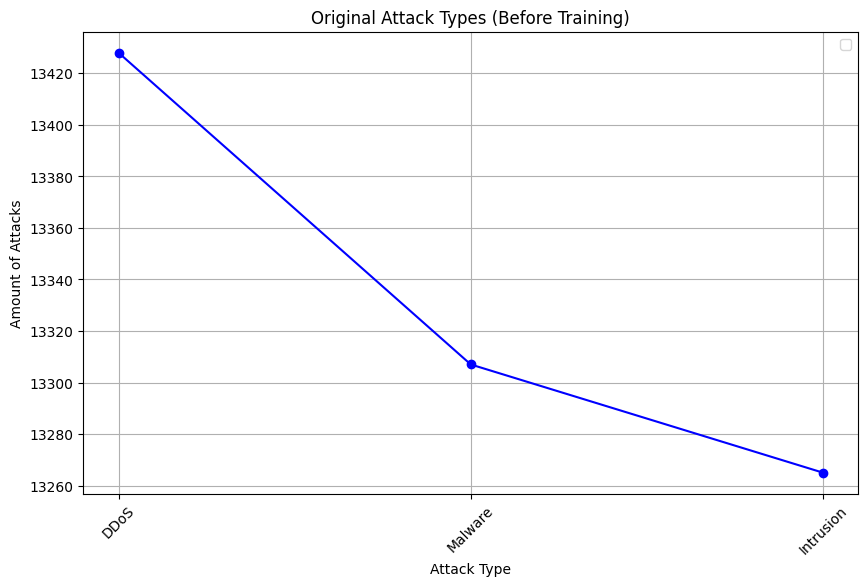

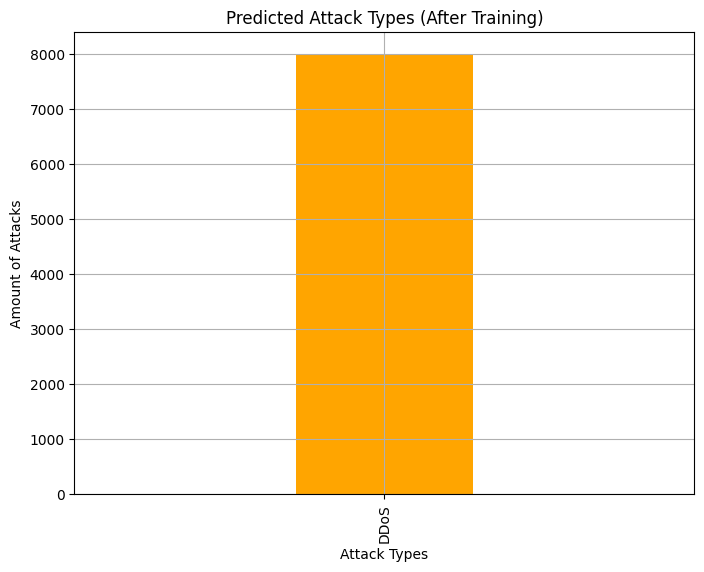

In [3]:
import pandas as pd
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the data again (from the original CSV file)
file_path = r'cybersecurity_attacks.csv'
data = pd.read_csv(file_path)

# Clean the dataset
data_cleaned = data.ffill()

# Encode the target column ('Attack Type')
label_encoder = LabelEncoder()
data_cleaned['Attack Type'] = label_encoder.fit_transform(data_cleaned['Attack Type'])

# Rename the target column to "labels"
data_cleaned = data_cleaned.rename(columns={'Attack Type': 'labels'})

# Convert 'Severity Level' to string (if needed)
data_cleaned['Severity Level'] = data_cleaned['Severity Level'].astype(str)

# Prepare the dataset for modeling
data_cleaned = data_cleaned[['Severity Level', 'labels']]
dataset = Dataset.from_pandas(data_cleaned)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

# Ensure the padding token is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as padding token

# Tokenization function
def tokenize_function(examples):
    tokenized_text = tokenizer(examples['Severity Level'], padding="max_length", truncation=True)
    tokenized_text['labels'] = examples['labels']
    return tokenized_text

# Apply tokenization
dataset = dataset.map(tokenize_function, batched=True)

# Split the dataset into train and test
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# Load the model from the saved checkpoint (make sure the path is correct)
model = AutoModelForSequenceClassification.from_pretrained("./test2/checkpoint-2000")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

# Training arguments
training_args = TrainingArguments(
    output_dir="./test2/checkpoint-2000",
    per_device_eval_batch_size=8,
)

# Initialize the trainer with the loaded model and dataset
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
)

# ------------------------ PLOT 1: Original Attack Types as Line Graph ------------------------
original_attack_type_counts = data_cleaned['labels'].value_counts()
original_attack_types = label_encoder.inverse_transform(original_attack_type_counts.index)

plt.figure(figsize=(10, 6))
plt.plot(original_attack_types, original_attack_type_counts.values, marker='o', linestyle='-', color='blue')
plt.title("Original Attack Types (Before Training)")
plt.xlabel("Attack Type")
plt.ylabel("Amount of Attacks")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# ------------------------ PLOT 2: Predicted Attack Types as Horizontal Bar Chart ------------------------
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)
predicted_attack_types = label_encoder.inverse_transform(pred_labels)
predicted_attack_type_counts = pd.Series(predicted_attack_types).value_counts()

# Horizontal Bar Chart
plt.figure(figsize=(8, 6))
predicted_attack_type_counts.plot(kind='bar', color='orange', width = 0.2)
plt.title("Predicted Attack Types (After Training)")
plt.xlabel("Attack Types")
plt.ylabel("Amount of Attacks")
plt.grid(True)
plt.show()
